## Quantitaive and qualitative data inspection

In [2]:
# libraries 
import numpy as np
import h5py
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import display
import os
import sys
sys.path.append('../../src')

from utils.evaluate_utils import get_indices
# from prepare_data.kspace_sampling import adjust_image_size_centered

### Qualitative analysis

In [3]:
path_invivo = '../../data/PairedInvivo/Volunteer3_4D_WholeHeart_2mm_20ms.h5' #output_dir = 'data/paired_invivo'; output_filename = 'v4_wholeheart_25mm_40ms.h5'

# load data
with h5py.File(path_invivo, 'r') as h5:
    print(h5.keys())
    u = np.array(h5['u']).transpose(3, 0, 1,2)
    v = np.array(h5['v']).transpose(3, 0, 1,2)
    w = np.array(h5['w']).transpose(3, 0, 1,2)
    print('vencs:', h5['u_max'][0],  h5['v_max'][0], h5['w_max'][0],)
    # mask = np.array(data['mask'])
    print(u.shape)

idx_spatial = np.index_exp[:, :, 20:90, :]


# u = u[idx_spatial]
# mask = mask[idx_spatial]

# u *= mask
T, X, Y, Z = u.shape


@widgets.interact(frame=(0, T-1), x=(0, X-1), axis=[0, 1, 2])
def visualize_lr(frame=0, x=0, axis=0):
    plt.figure(figsize=(7, 7))
    N = 2
    idxs_hr = get_indices(frame, axis, x)

    plt.subplot(1, N, 1)
    plt.imshow(u[idxs_hr])
    plt.title('u')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(v[idxs_hr])
    plt.title('v')
    plt.axis('off')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../data/PairedInvivo/Volunteer3_4D_WholeHeart_2mm_20ms.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [1]:
path_invivo = '../../data/PIA/THORAX/P03/h5/P03.h5' 

# load data
with h5py.File(path_invivo, 'r') as h5:
    print(h5.keys())
    u = np.array(h5['u'])
    v = np.array(h5['v'])
    w = np.array(h5['w'])
    print('vencs:', h5['u_max'][0],  h5['v_max'][0], h5['w_max'][0],)
    mask = np.array(h5['mask'])
    if mask.ndim == 3:
        mask = mask[np.newaxis, ...]
        mask = np.repeat(mask, u.shape[0], axis=0)
    print(u.shape)

idx_spatial = np.index_exp[:, :, 20:90, :]
# u = u[idx_spatial]
# mask = mask[idx_spatial]

# u *= mask
T, X, Y, Z = u.shape


@widgets.interact(frame=(0, T-1), x=(0, X-1), axis=[0, 1, 2])
def visualize_lr(frame=0, x=0, axis=0):
    plt.figure(figsize=(12, 7))
    N = 4
    idxs_hr = get_indices(frame, axis, x)

    plt.subplot(1, N, 1)
    plt.imshow(u[idxs_hr]*mask[idxs_hr])
    plt.title('u')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(v[idxs_hr]*mask[idxs_hr])
    plt.title('v')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(w[idxs_hr]*mask[idxs_hr])
    plt.title('v')
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(mask[idxs_hr])
    plt.title('mask')
    # plt.axis('off')

NameError: name 'h5py' is not defined

In [ ]:
# h5_files = ['../../data/CARDIAC/M5_2mm_step2_static_dynamic.h5','../../data/CARDIAC/M6_2mm_step2_static_dynamic.h5', ]
h5_files = ['../../results/kspacesampling/FromAlex/result_cs.h5','../../results/kspacesampling/res_cs16_9coils_large.h5', ]
file_label = ['result_cs',]

# columns to load from data
# colnames = ['u', 'v', 'w',  'mask'] #
colnames = ['res_vel']

# load data
h5 = {}
for h5_file, label in zip(h5_files, file_label):
    with h5py.File(h5_file, 'r') as f:
        for vel in colnames:
            h5[f'{label}_{vel}'] = np.array(f[vel]).squeeze()

            if h5[f'{label}_{vel}'].dtype == np.complex64:
                h5[f'{label}_{vel}_abs'] = np.abs(h5[f'{label}_{vel}'])
                h5[f'{label}_{vel}_ang'] = np.angle(h5[f'{label}_{vel}'])


if 'abs' in h5.keys() and 'ang' in h5.keys():
    colnames = [f'{col}_abs' for col in colnames] + [f'{col}_ang' for col in colnames]

print(colnames)

In [ ]:

T, X, Y, Z= h5[f'{file_label[0]}_{colnames[0]}'].shape

print(T, X, Y, Z)
@widgets.interact(frame=(0, T-1), x = (0, X-1), vel=colnames, axis=[0, 1, 2])
def f(frame=5, x = 10, vel = f'{file_label[0]}_{colnames[0]}', axis = 0):
    plt.figure(figsize=(7,7))
    N = 2
    idxs = get_indices(frame,axis, x)


    plt.subplot(1, N, 1)
    plt.imshow(np.abs(h5[f'{label}_{vel}'][idxs]))#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title('abs')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(np.angle(h5[f'{label}_{vel}'][idxs]))#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title('angle')
    plt.axis('off')
    

In [4]:
data_dir = '../../data'
path_datamodel = f'{data_dir}/CARDIAC/M4_2mm_step2_static_dynamic.h5'

# load data
with h5py.File(path_datamodel, mode = 'r') as h5:
    lr_u = np.array(h5['u'])[::2, :, :, :]
    venc_u = np.max(np.array(h5['u_max']))
    mask = np.array(h5['mask']).squeeze()[::2, :, :, :]

max_u = np.max(lr_u)
min_u = np.min(lr_u)


#adjust image size
data_cs = h5[f'{file_label[0]}_res_vel']
data_cs = adjust_image_size_centered(data_cs, lr_u.shape)
data_cs *= mask

print(data_cs.shape, data_cs.min(), data_cs.max(),  lr_u.shape)

@widgets.interact(frame=(0, data_cs.shape[0]-1), x = (0, data_cs.shape[1]-1), axis=[0, 1, 2])
def f(frame=5, x = 10,  axis = 0):
    plt.figure(figsize=(7,7))
    N = 2
    idxs = get_indices(frame,axis, x)


    plt.subplot(1, N, 1)
    plt.imshow(data_cs[idxs])#,  vmin = min_v, vmax = max_v, cmap='viridis')
    plt.title('compresses sensing recon')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(lr_u[idxs],  vmin = min_u, vmax = max_u, cmap='viridis')
    plt.title('original')
    plt.axis('off')


NameError: name 'file_label' is not defined

In [ ]:
#TODO: add vmin and vmax to the plot
# make use to also choose the colname (data) such that magnitude and velocity can be plotted next to each other

# show interactive plot

T, X, Y, Z= h5[f'{file_label[0]}_{colnames[0]}'].shape

print(T, X, Y, Z)
@widgets.interact(frame=(0, T-1), x = (0, X-1), vel=colnames, axis=[0, 1, 2])
def f(frame=5, x = 10, vel = f'{file_label[0]}_{colnames[0]}', axis = 0):
    plt.figure(figsize=(7,7))
    N = len(h5_files)
    idxs = get_indices(frame,axis, x)

    for i, t_name in enumerate(file_label):

        plt.subplot(1, N, i+1)
        plt.imshow(h5[f'{label}_{vel}'][idxs])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
        plt.title(t_name)
        plt.axis('off')
    

In [ ]:
for vel in colnames:
    print(np.linalg.norm(h5[f'{file_label[0]}_{vel}'][:, :, :, 1:] - h5[f'{file_label[1]}_{vel}']))

plt.plot(np.mean(h5[f'{file_label[0]}_u'], axis=(1, 2, 3)), label='Model5')
plt.plot(np.mean(h5[f'{file_label[1]}_u'], axis=(1, 2, 3)), label='Model6')


(99, 62, 58, 84) (99, 62, 58, 84)


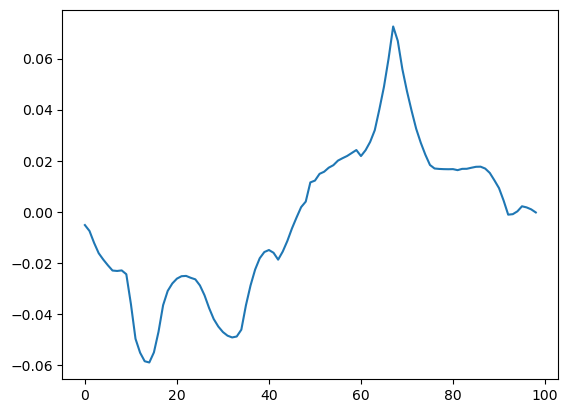

In [5]:
data_dir = '../../data/CARDIAC'
path_datamodel = f'{data_dir}/M4_2mm_step1_static_dynamic.h5'

with h5py.File(path_datamodel, mode = 'r') as h5:
    u = np.array(h5['u'])
    mask = np.array(h5['mask']).squeeze()

print(u.shape, mask.shape)
plt.plot(np.mean(u, axis=(1, 2, 3), where = mask.astype(bool)), label='HR')

In [7]:
data_dir = '../../data/CARDIAC'
hr_filename = 'M2_2mm_step2_cs_invivoP04_hr.h5'
lr_filename = 'M2_2mm_step2_cs_invivoP04_lr.h5'
# lr_filename = 'output_M4_lr_magninvivo_noise90TBD.h5'

# Load the lr file
with h5py.File(f'{data_dir}/{lr_filename}', 'r') as f:
    lr_u = np.array(f['u'])  
    venc_u = np.max(np.array(f['u_max']))
    venc_v = np.max(np.array(f['v_max']))
    venc_w = np.max(np.array(f['w_max']))

# Load the hr file
with h5py.File(f'{data_dir}/{hr_filename}', 'r') as f:
    hr_u = np.array(f['u'])
    mask = np.array(f['mask'])
    


print(venc_u, venc_v, venc_w)


min_u = np.quantile(hr_u[np.where(mask !=0)].flatten(), 0.01)
max_u = np.quantile(hr_u[np.where(mask !=0)].flatten(), 0.99)


# lr_u *=mask[::2]
# Visualize the lr data
T, X, Y, Z = hr_u.shape
@widgets.interact(frame=(0, T-1), x=(0, X-1), axis=[0, 1, 2])
def visualize_lr(frame=0, x=0, axis=0):
    plt.figure(figsize=(7, 7))
    N = 2
    idxs_hr = get_indices(frame, axis, x)
    idxs_lr = get_indices(frame//2, axis, x)

    plt.subplot(1, N, 1)
    plt.imshow(lr_u[idxs_lr], vmin=min_u, vmax=max_u, cmap='plasma')
    plt.title('LR Data ')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(hr_u[idxs_hr], vmin=min_u, vmax=max_u, cmap='plasma')
    plt.title('HR Data')
    plt.axis('off')

2.957847 2.957847 2.957847


interactive(children=(IntSlider(value=0, description='frame', max=49), IntSlider(value=0, description='x', max…

In [10]:
print(lr_u.shape)

(25, 84, 60, 96)


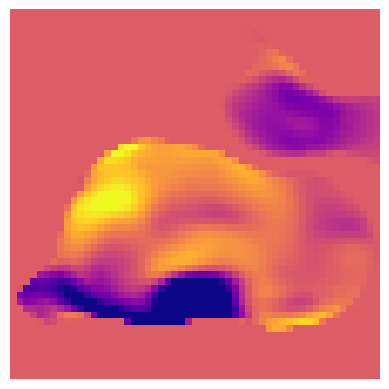

In [16]:

timepoints = [12, 13, 14, 15]
for timepoint in timepoints:
    # extract slices and save 
    idx_slice_hr = np.index_exp[timepoint, 53, 5::, 5:60]
    idx_slice_lr = np.index_exp[timepoint//2, 53, 5::, 5:60]
    plt.imshow(lr_u[idx_slice_lr], vmin=min_u, vmax=max_u, cmap='plasma')
    plt.axis('off')
    plt.savefig(f'lr_data_{timepoint//2}.png', bbox_inches='tight', transparent=True)
    plt.imshow(hr_u[idx_slice_hr], vmin=min_u, vmax=max_u, cmap='plasma')
    plt.axis('off')
    plt.savefig(f'hr_data_{timepoint}.png', bbox_inches='tight', transparent=True)

In [ ]:
plt.plot(range(0, 50, 2), np.mean(lr_u, axis=(1, 2, 3), where = mask[::2].astype(bool)), label='LR')
plt.plot(np.mean(hr_u, axis=(1, 2, 3), where = mask.astype(bool)), label='HR')
plt.xlabel('Frame')
plt.ylabel('Mean Velocity (m/s)')
plt.legend()

In [ ]:

def bbox2_3D(img):
    ''' code copied from https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array'''

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(h5[f'{file_label[0]}_mask'])

print('mask shape', h5[f'{file_label[0]}_mask'].shape[1:])
print(rmin, rmax, cmin, cmax, zmin, zmax)

bbox = np.zeros(h5[f'{file_label[0]}_mask'].shape[1:])
bbox[cmin:cmax,zmin:zmax,rmin:rmax] = 1


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
mask = h5[f'{file_label[0]}_mask'].squeeze()[0]

x, y, z = np.where(mask == 1)
x1, y1, z1 = np.where(h5[f'{file_label[0]}_u'][0] != 0)
x2, y2, z2 = np.where(bbox == 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.scatter(x1, y1, z1)
ax.scatter(x2, y2, z2, alpha = 0.01, c ='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, X)
ax.set_ylim(0, Y)
ax.set_zlim(0, Z)
plt.show()

Create gif Animation of data

In [ ]:
min_u = None
max_u = None

eval_dir = '../../results/interpolation/plots'
if not os.path.exists(eval_dir):
    os.makedirs(eval_dir)

def create_temporal_comparison_gif_single(idx, data, title):
    N_frames = data.shape[0]
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_u, vmax=max_u)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init, frames = N_frames,interval = 100, ) # in ms)


    anim.save(f'{eval_dir}/Animate_{title}_single.gif', fps=10)

t, x, y, z = h5[f'{file_label[0]}_u'].shape
create_temporal_comparison_gif_single(x//2, h5[f'{file_label[0]}_v'], file_label[0])